# Excited State from TD-DFT

Simple Juypter notebook that performs TD-DFT (Time-dependent density-functional theory) using pyscf. 

Part of the code take from and inspired by https://www.andersle.no/posts/2022/mo/mo.html

## Setup python environment and imports

In [1]:
%%capture
!pip install numpy
!pip install scipy
!pip install Cython
!pip install pandas
!pip install sklearn
!pip install statsmodels
!pip install matplotlib
!pip install rdkit
!pip install py3Dmol
!pip install ipywidgets
!pip install sphinx
!pip install nbsphinx
!pip install pydata-sphinx-theme
!pip install lxml
!pip install fortecubeview
!pip install pythreejs
!pip install scikit-image
!pip install pyscf
!pip install shap
!pip install catboost
!pip install graphviz

In [35]:
import pathlib

# RDKit imports:
from rdkit import Chem
from rdkit.Chem import (
    AllChem,
    rdCoordGen,
)
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True  # Use higher quality images for molecules

# For visualization of molecules and orbitals:
import py3Dmol
import fortecubeview

# pyscf imports:
from pyscf import gto, scf, dft, tddft, tools 

from pyscf.data.nist import HARTREE2EV

# For plotting
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

# For numerics:
import numpy as np

from google.colab import output
output.enable_custom_widget_manager()

## Function Definitions

In [7]:
def get_xyz(molecule, optimize=False):
    """Get xyz-coordinates for the molecule"""
    mol = Chem.Mol(molecule)
    mol = AllChem.AddHs(mol, addCoords=True)
    AllChem.EmbedMolecule(mol)
    if optimize:  # Optimize the molecules with the MM force field:
        AllChem.MMFFOptimizeMolecule(mol)
    xyz = []
    for lines in Chem.MolToXYZBlock(mol).split("\n")[2:]:
        strip = lines.strip()
        if strip:
            xyz.append(strip)
    xyz = "\n".join(xyz)
    return mol, xyz

In [8]:
def run_calculation_tddft(xyz, functional="b3lyp", basis="sto-3g", nstates=5):
    """Calculate the energy (+ additional things like MO coefficients) with pyscf."""
    mol = gto.M(
        atom=xyz,
        basis=basis,
        unit="ANG",
        symmetry=False,
    )
    mol.build()
    mf = dft.RKS(mol)
    mf.xc = functional
    mf.kernel()
    td = tddft.TDDFT(mf)
    td.nstates = nstates
    td.kernel()
    return mf, mol, td 

In [36]:
def write_cube_files(
    max_homo_lumo=5, prefix="", dirname=".", margin=5, write_all_orbitals=False
):
    """Write cube files for the given coefficients."""
    path = pathlib.Path(dirname)
    path.mkdir(parents=True, exist_ok=True)

    # find index of HOMO and LUMO
    lumo = float("inf")
    lumo_idx = None
    homo = -float("inf")
    homo_idx = None
    for i, (energy, occ) in enumerate(zip(mf.mo_energy, mf.mo_occ)):
        if occ > 0 and energy > homo:
            homo = energy
            homo_idx = i
        if occ == 0 and energy < lumo:
            lumo = energy
            lumo_idx = i
    
    if(write_all_orbitals): 
      for i in range(mf.mo_coeff.shape[1]):
        outfile = f"{prefix}Orbital-{i:02d}.cube"
        outfile = path / outfile
        print(f"Writing {outfile}")
        tools.cubegen.orbital(mol, outfile, mf.mo_coeff[:, i], margin=margin)
    else:
      print(f"HOMO (index): {homo_idx+1}")
      print(f"LUMO (index): {lumo_idx+1}")
      print("")
      outfile = f"{prefix}HOMO.cube"
      outfile = path / outfile
      print(f"Writing {outfile}")
      tools.cubegen.orbital(mol, outfile, mf.mo_coeff[:, homo_idx], margin=margin)

      outfile = f"{prefix}LUMO.cube"
      outfile = path / outfile
      print(f"Writing {outfile}")
      tools.cubegen.orbital(mol, outfile, mf.mo_coeff[:, lumo_idx], margin=margin)

      for i in range(1,max_homo_lumo+1):
        outfile = f"{prefix}HOMO_minus-{i:02d}.cube"
        outfile = path / outfile
        print(f"Writing {outfile}")
        tools.cubegen.orbital(mol, outfile, mf.mo_coeff[:, homo_idx-i], margin=margin)

        outfile = f"{prefix}LUMO_plus-{i:02d}.cube"
        outfile = path / outfile
        print(f"Writing {outfile}")
        tools.cubegen.orbital(mol, outfile, mf.mo_coeff[:, lumo_idx+i], margin=margin)

In [18]:
def GaussianPeak(x,mean,sigma):
  return np.exp(-(x-mean)**2/(2*sigma**2))

def plot_spectrum(exc,osc,width=0.2):
  x_min = round(exc[0]-4*width)
  x_max = round(exc[-1]+4*width+0.5)
  x=np.linspace(x_min,x_max,1000)
  y=np.zeros(x.size)
  for i, e in enumerate(exc):
    if not np.isnan(osc[i]):
      y+=osc[i]*GaussianPeak(x,e,width)
  
  plt.plot(x,y)
  plt.xlabel("Excitation [eV]")
  plt.ylabel("Intensity")
  plt.xlim([x_min,x_max])
  for i, e in enumerate(exc):
    if not np.isnan(osc[i]):
      plt.stem(e,osc[i],linefmt="--")
  plt.show()

## Definition of Molecule from SMILES String

**Here you should define the smiles string for the molecule you want to consider**




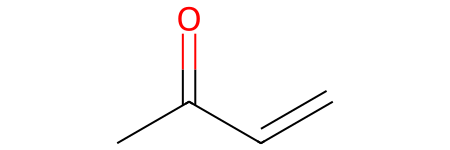

In [26]:
molecule_smiles = "CC(=O)C=C" #@param {type:"string"}

molecule_name = "Mol"
molecule = Chem.MolFromSmiles(molecule_smiles)  # Generate the molecule from smiles
molecule 

## Setup of Molecule

In [27]:
molecule3d, xyz = get_xyz(molecule, optimize=True)
print(xyz)

C     -1.364494   -0.109020    0.778374
C     -0.279953   -0.549474   -0.168541
O     -0.149714   -1.728918   -0.488131
C      0.611138    0.511382   -0.719322
C      1.604106    0.203916   -1.562455
H     -1.175379    0.898385    1.158810
H     -2.325195   -0.121694    0.257543
H     -1.393078   -0.791301    1.632574
H      0.428012    1.534800   -0.416289
H      1.791260   -0.821964   -1.870226
H      2.253298    0.973890   -1.965073


In [29]:
view = py3Dmol.view(
    data=Chem.MolToMolBlock(molecule3d),
    style={"stick": {}, "sphere": {"scale": 0.3}},
    width=300,
    height=300,
  )
view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## DFT and TD-DFT Calculations

In [30]:
mf, mol, td = run_calculation_tddft(xyz, basis="cc-pVDZ")

converged SCF energy = -231.105763599981
TD-SCF states [0, 1, 3, 4] not converged.
Excited State energies (eV)
[ 0.75648283  1.67547728  3.44009572  5.91932598 10.25948942]


/usr/local/lib/python3.9/dist-packages/pyscf/tdscf/rhf.py:1018: RuntimeWarning: invalid value encountered in sqrt
  norm = numpy.sqrt(.5/norm)  # normalize to 0.5 for alpha spin


## Analysis of Results

### DFT Results



In [31]:
mf.analyze(verbose=3)

**** MO energy ****
MO #1   energy= -19.1215007010894  occ= 2
MO #2   energy= -10.2701194246309  occ= 2
MO #3   energy= -10.2046545872412  occ= 2
MO #4   energy= -10.1971783826983  occ= 2
MO #5   energy= -10.1881164316269  occ= 2
MO #6   energy= -1.02745426214272  occ= 2
MO #7   energy= -0.790814922379956 occ= 2
MO #8   energy= -0.741469602137676 occ= 2
MO #9   energy= -0.621401928933048 occ= 2
MO #10  energy= -0.522205737748964 occ= 2
MO #11  energy= -0.483187606564612 occ= 2
MO #12  energy= -0.454061380039902 occ= 2
MO #13  energy= -0.442546244174782 occ= 2
MO #14  energy= -0.409768928124617 occ= 2
MO #15  energy= -0.389032817148302 occ= 2
MO #16  energy= -0.37172701344963  occ= 2
MO #17  energy= -0.358465820734121 occ= 2
MO #18  energy= -0.279453068572337 occ= 2
MO #19  energy= -0.24558962076924  occ= 2
MO #20  energy= -0.0614676144259635 occ= 0
MO #21  energy= 0.0624600310832202 occ= 0
MO #22  energy= 0.0662340904814402 occ= 0
MO #23  energy= 0.0890540480860552 occ= 0
MO #24  energ

((array([1.99988341e+00, 1.02866973e+00, 4.01224771e-03, 1.08366370e+00,
         1.10690994e+00, 1.08646698e+00, 4.35263104e-03, 5.83090708e-03,
         4.27142955e-03, 4.24836458e-04, 1.10661566e-03, 4.87701135e-04,
         1.36588252e-03, 1.39020329e-03, 1.99989940e+00, 9.38163474e-01,
         9.40048319e-03, 9.11503248e-01, 8.78877331e-01, 8.58695004e-01,
         5.36106382e-03, 2.01336437e-02, 4.74041871e-03, 4.60580074e-03,
         3.87038644e-03, 1.59160421e-03, 1.37270088e-03, 2.55256990e-03,
         1.99995362e+00, 1.69986090e+00, 7.77294190e-03, 1.65240954e+00,
         1.50135120e+00, 1.53569637e+00, 3.39044293e-03, 2.93711794e-03,
         2.44222642e-03, 1.84306730e-03, 2.49031292e-03, 1.28635096e-03,
         1.40120199e-04, 3.74274214e-03, 1.99988954e+00, 9.99016116e-01,
         5.57572669e-03, 1.03201033e+00, 1.05851890e+00, 1.02997909e+00,
         5.06009543e-03, 6.93318914e-03, 3.86117456e-03, 1.06183426e-03,
         8.24660555e-04, 7.00423064e-04, 1.63307639

### TD-DFT Results

In [32]:
td.analyze(verbose=4)


** Singlet excitation energies and oscillator strengths **
Excited State   1:      0.75648 eV   1638.96 nm  f=nan
Excited State   2:      1.67548 eV    739.99 nm  f=0.2780
       7 -> 20       -0.18973
       8 -> 21       -0.10011
       9 -> 21        0.16138
      10 -> 20        0.30517
      10 -> 21        0.11013
      10 -> 22        0.12048
      10 -> 26        0.10682
      10 -> 31       -0.10055
      11 -> 20       -0.22134
      12 -> 22       -0.10300
      12 -> 24        0.14297
      13 -> 20        0.14038
      13 -> 23       -0.13078
      13 -> 24       -0.10640
      13 -> 26        0.18740
      14 -> 20       -0.19035
      14 -> 21       -0.14678
      15 -> 20       -0.17441
      15 -> 22       -0.17320
      15 -> 30        0.10697
      16 -> 20        0.50900
      16 -> 21        0.34304
      16 -> 22        0.19067
      16 -> 28        0.10796
      16 -> 29        0.13324
      16 -> 31        0.11597
      16 -> 34        0.12056
      17 -> 21   

## Plot Spectrum

Here we plot the spectra by taking each excitation as a Gaussian peak with a finite width that represent broading effects. Each Gaussian peak is weighted with the oscillator strength.

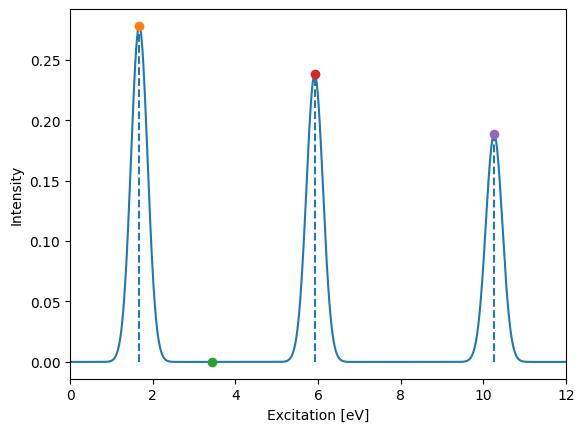

In [33]:
exc=td.e*HARTREE2EV
osc=td.oscillator_strength()

# Peak width in eV
peak_width_eV=0.2

plot_spectrum(exc,osc,width=0.2)

## Setup Orbitals 

In [37]:
!rm -rf cube_files
write_cube_files(
   dirname="cube_files",
   write_all_orbitals=False
)

HOMO (index): 19
LUMO (index): 20

Writing cube_files/HOMO.cube
Writing cube_files/LUMO.cube
Writing cube_files/HOMO_minus-01.cube
Writing cube_files/LUMO_plus-01.cube
Writing cube_files/HOMO_minus-02.cube
Writing cube_files/LUMO_plus-02.cube
Writing cube_files/HOMO_minus-03.cube
Writing cube_files/LUMO_plus-03.cube
Writing cube_files/HOMO_minus-04.cube
Writing cube_files/LUMO_plus-04.cube
Writing cube_files/HOMO_minus-05.cube
Writing cube_files/LUMO_plus-05.cube


## Visualize Orbitals

In [40]:
fortecubeview.plot(path="./cube_files/", width=600, height=300, colorscheme='national', sumlevel=0.7)

CubeViewer: listing cube files from the directory ./cube_files/
Reading 12 cube files


HTML(value='\n        <style>\n           .jupyter-widgets-output-area .output_scroll {\n                heigh…

interactive(children=(Select(description='Cube files:', options=('./cube_files/HOMO.cube', './cube_files/HOMO_…

TraitError: ignored